<a href="https://colab.research.google.com/github/Mayankkestwal10/fast-ai/blob/master/Create_Your_Own_Datasets_Google_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
folder = "black"
file = "urls_black.txt"

In [0]:
folder = "teddys"
file = "urls_teddys.txt"

In [0]:
folder = "grizzly"
file = "urls_grizzly.txt"

In [0]:
path = Path('data/bears')
dest = path/folder
#dest.mkdir(parents=True,exist_ok=True)

In [9]:
path.ls()

[PosixPath('data/bears/black'),
 PosixPath('data/bears/teddys'),
 PosixPath('data/bears/grizzly')]

In [0]:
#Download images from urls
download_images(path/folder/file,dest,max_pics=200)

In [0]:
#Verify images have no error associated

classes = ['black','teddys','grizzly']

for c in classes:
  print(c)
  verify_images(path/c,delete=True,max_workers=500)

<h2>View data</h2>

In [0]:
np.random.seed(42)

data = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,ds_tfms=get_transforms(),size=224,num_workers=4).normalize(imagenet_stats)

In [21]:
data.classes

['black', 'grizzly', 'teddys']

In [22]:
data.c

3

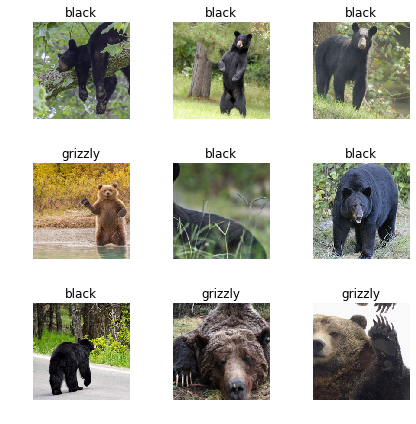

In [23]:
data.show_batch(rows=3,figsize=(6,6))

In [24]:
len(data.train_ds), len(data.valid_ds)

(222, 55)

<h2>Training model</h2>

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 80699873.69it/s]


In [26]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.394792,0.421892,0.109091,00:13
1,0.837234,0.123877,0.036364,00:12
2,0.596583,0.124776,0.054545,00:12
3,0.470861,0.130279,0.054545,00:12


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-04


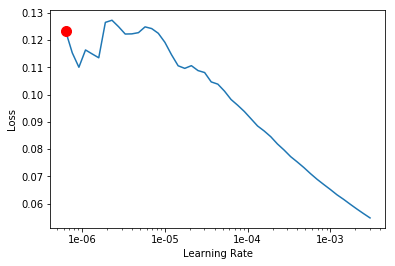

In [31]:
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.136908,0.129776,0.054545,00:12
1,0.133174,0.132078,0.054545,00:13


In [0]:
learn.save('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

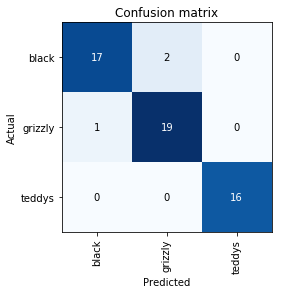

In [35]:
interp.plot_confusion_matrix()

<h2>Cleaning up</h2>
<p>Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.</p>

In [0]:
from fastai.widgets import *

In [0]:
losses, idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [37]:
top_loss_paths

ImageList (55 items)
Image (3, 200, 300),Image (3, 254, 400),Image (3, 776, 554),Image (3, 2333, 3500),Image (3, 512, 1024)
Path: data/bears

In [0]:
db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(),size=224).databunch())

In [0]:
learn_cln = cnn_learner(db,models.resnet34,metrics=error_rate)

In [0]:
learn_cln.save('stage-2')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [51]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

<h2>Production</h2>

In [0]:
learn.export()

In [0]:
#defaults.device = torch.device('cpu')

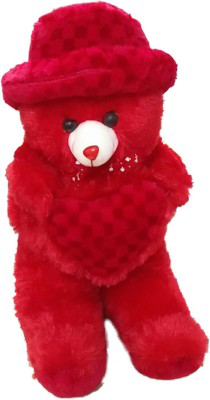

In [47]:
img = open_image(path/'teddys'/'00000022.jpeg')
img

In [0]:
learn = load_learner(path)

In [48]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category teddys



```
# This is formatted as code
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```



<h2>Things that go wrong</h2>
<ul>
  <li>Most of the time things will train fine with the defaults</li>
  <li>There's not much you really need to tune (despite what you've heard!)
</li>
  <li>Most likely are</li>
  <ul><li>Learning rate</li>
    <li>Number of epochs</li></ul>
</ul>


<h3>Learning rate TOO HIGH</h3>

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [52]:
learn.fit_one_cycle(1,max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,4.209529,4741130752.000000,0.709091,00:12


<h3>Learning rate (LR) too low¶</h3>

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [54]:
learn.fit_one_cycle(5,max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.677280,1.267084,0.727273,00:13
1,1.633499,1.251198,0.727273,00:12
2,1.608469,1.244661,0.745455,00:12
3,1.608342,1.259532,0.745455,00:13
4,1.583417,1.281793,0.745455,00:13


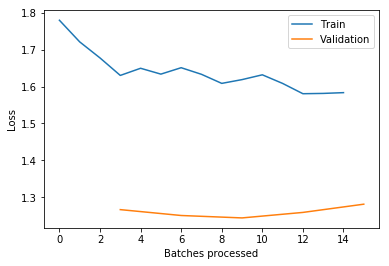

In [55]:
learn.recorder.plot_losses()

<h3>Too few epochs</h3>

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

In [57]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.122673,0.254232,0.054545,00:13


<h3>Too many epochs</h3>

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=28, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)

In [0]:
learn.unfreeze()

In [62]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.275817,0.996309,0.510040,00:16
1,1.237930,0.994929,0.502008,00:13
2,1.218067,0.982939,0.481928,00:13
3,1.189700,0.963215,0.469880,00:13
4,1.133528,0.930449,0.453815,00:13
5,1.074750,0.886835,0.425703,00:13
6,1.005086,0.833553,0.365462,00:13
7,0.931218,0.772744,0.329317,00:13
8,0.861522,0.707527,0.269076,00:12
9,0.791675,0.642218,0.228916,00:13
